In [1]:
def active_params(dmodel, n_blocks, gated=False):
    if not gated:
        params = 12 * (dmodel **2) * n_blocks
        return params
    else:
        params = 16 * (dmodel **2) * n_blocks
        return params

def calc_tokens(cutoff, batch_size, n_steps):
    tokens = cutoff * batch_size * n_steps
    return tokens

def compute_optimal(dmodel, n_blocks, cutoff, batch_size, tok_param_ratio=20, gated=False):
    params = active_params(dmodel, n_blocks, gated=gated)
    one_iter_tokens = calc_tokens(cutoff, batch_size, 1)
    n_steps = tok_param_ratio * params / one_iter_tokens
    return n_steps

In [2]:
batch_size = 256
cutoff = 256

dmodel = 512
n_blocks = 8
gated = True

n_steps_copt = compute_optimal(dmodel, n_blocks, cutoff, batch_size, tok_param_ratio=20, gated=gated)

print(n_steps_copt)

10240.0


In [15]:
import math

In [45]:
class CosineScheduler_old():
    def __init__(
        self,
        lr_warmup_steps: int,
        lr: float,
        final_lr_step: int,
        final_lr_fraction: float,
        ratio_lr,
        scheduler_fraction,
    ):
        self.lr_warmup_steps = lr_warmup_steps
        self.lr = lr
        self.final_lr_step = final_lr_step
        self.final_lr_fraction = final_lr_fraction
        self.ratio = ratio_lr
        self.fraction = scheduler_fraction

    def get_lr(self, step: int):
        if step < self.lr_warmup_steps:
            return self.lr * (step + 1) / self.lr_warmup_steps
        # cosine schedule that ends at final_lr_fraction * lr, then constant
        elif step < self.final_lr_step:
            return self.final_lr_fraction * self.lr + 0.5 * (
                1 - self.final_lr_fraction
            ) * self.lr * (
                1
                + math.cos(
                    math.pi
                    * (step - self.lr_warmup_steps)
                    / (self.final_lr_step - self.lr_warmup_steps)
                )
            )
        else:
            return self.lr * self.final_lr_fraction

    # had to overwrite it here, because AbstractLRScheduler doesn't know final_lr_fraction and othr params necessary for relative lr fractions
    def set_lr(self, step: int):
        new_lr = self.get_lr(step)
        if step < self.lr_warmup_steps:
            relative_lr = new_lr
        elif step < self.final_lr_step:
            relative_lr = (new_lr - self.lr) * (
                1 - self.final_lr_fraction * self.fraction
            ) / (1 - self.final_lr_fraction) + self.lr
            relative_lr = relative_lr
        else:
            relative_lr = new_lr * self.fraction
        return relative_lr * self.ratio

In [46]:
class CosineScheduler():
    def __init__(
        self,
        lr_warmup_steps: int,
        lr: float,
        final_lr_step: int,
        final_lr_fraction: float,
        ratio_lr,
        scheduler_fraction,
    ):
        self.lr_warmup_steps = lr_warmup_steps
        self.lr = lr
        self.final_lr_step = final_lr_step
        self.final_lr_fraction = final_lr_fraction
        self.ratio = ratio_lr
        self.fraction = scheduler_fraction

    def get_lr(self, step: int, start_lr=None, end_lr=None):
        start_lr = start_lr if start_lr is not None else self.lr
        end_lr = end_lr if end_lr is not None else self.lr * self.final_lr_fraction

        if step < self.lr_warmup_steps:
            return start_lr * (step + 1) / self.lr_warmup_steps
        # cosine schedule that ends at final_lr_fraction * lr, then constant
        elif step < self.final_lr_step:
            return end_lr + 0.5 * (1 - end_lr/start_lr) * start_lr * (
                1
                + math.cos(
                    math.pi
                    * (step - self.lr_warmup_steps)
                    / (self.final_lr_step - self.lr_warmup_steps)
                )
            )
        else:
            return end_lr

    # had to overwrite it here, because AbstractLRScheduler doesn't know final_lr_fraction and othr params necessary for relative lr fractions
    def set_lr(self, step: int):
        
        start_lr = self.lr * self.ratio
        end_lr = self.lr * self.final_lr_fraction * self.fraction
        return self.get_lr(step, start_lr=start_lr, end_lr=end_lr)


In [56]:
lr_warmup_steps: int = 0
lr: float = 50
final_lr_step = 10000
final_lr_fraction: float = 0.1
ratio_lr = 2
scheduler_fraction = 3

schd_old = CosineScheduler_old(lr_warmup_steps=lr_warmup_steps,
                               lr=lr,
                               final_lr_step=final_lr_step,
                               final_lr_fraction=final_lr_fraction,
                               ratio_lr=ratio_lr,
                               scheduler_fraction=scheduler_fraction)

schd_new = CosineScheduler(lr_warmup_steps=lr_warmup_steps,
                               lr=lr,
                               final_lr_step=final_lr_step,
                               final_lr_fraction=final_lr_fraction,
                               ratio_lr=ratio_lr,
                               scheduler_fraction=scheduler_fraction)

step = 10000

lr_old = schd_old.set_lr(step)
lr_new = schd_new.set_lr(step)

print(f'lr old: {lr_old}')
print(f'lr new: {lr_new}')


lr old: 30.0
lr new: 15.0


old took: 0.006365537643432617
new took: 0.007125139236450195


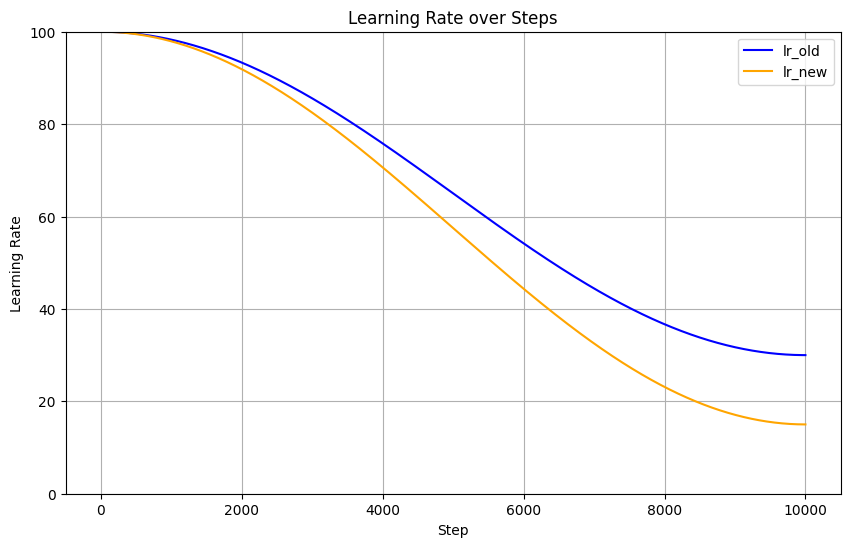

In [55]:
import matplotlib.pyplot as plt
from time import time

# Assuming `schd_old.set_lr(step)` and `schd_new.set_lr(step)` are defined
steps = range(0, 10001)  # Steps from 0 to 1000
start_old = time()
lr_old_values = [schd_old.set_lr(step) for step in steps]
print(f'old took: {time() - start_old}')
start_new = time()
lr_new_values = [schd_new.set_lr(step) for step in steps]
print(f'new took: {time() - start_new}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(steps, lr_old_values, label='lr_old', color='blue')
plt.plot(steps, lr_new_values, label='lr_new', color='orange')
plt.ylim((0, lr*ratio_lr))
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Steps')
plt.legend()
plt.grid(True)
plt.show()
